In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.insert(0, '..')
import tensorflow as tf
import tensorflow.contrib.slim as slim
from graphgan.utils import get_3d_direction
from graphgan.layers import *
from graphgan.gradient_penalty import gradient_penaly
from graphgan.datasets import graph_input_fn
from astropy.table import Table, join
from functools import partial

Populating the interactive namespace from numpy and matplotlib


## Load the data

In [2]:
mb2 = Table.read('/data2/graphgan/data/MBII_data.hdf5', path="/hydro_z1")

In [3]:
from sklearn.preprocessing import RobustScaler

# Reoriente all galaxies with respect to the tidal field
# Pre-processing the orientation of galaxies with respect to their host haloes and the tidal field

# Computes the size of groups
gids, idx, inv, counts  = unique(mb2['groups.groupId'],  return_index=True, return_inverse=True, return_counts=True)
mb2['group_size'] = counts[inv]

# Convert distances to Mpc
mb2['halos.x'] /= 1000.
mb2['halos.y'] /= 1000.
mb2['halos.z'] /= 1000.

mb2['groups.x'] /= 1000.
mb2['groups.y'] /= 1000.
mb2['groups.z'] /= 1000.

# Computes direction to the central
mb2['cen_x'] = mb2['groups.x'][idx][inv] - mb2['halos.x']
mb2['cen_y'] = mb2['groups.y'][idx][inv] - mb2['halos.y']
mb2['cen_z'] = mb2['groups.z'][idx][inv] - mb2['halos.z']
ncen = np.sqrt(mb2['cen_x']**2 + mb2['cen_y']**2 + mb2['cen_z']**2 ) 
mb2['cen_r'] = ncen

inds_cent = ncen == 0
ncen[ncen == 0] = 1
mb2['cen_x'] = mb2['cen_x']/ncen
mb2['cen_y'] = mb2['cen_y']/ncen
mb2['cen_z'] = mb2['cen_z']/ncen

# # First reorienting the tidal 
# a = (mb2['tid1000.c_x']*mb2['cen_x'] +
#      mb2['tid1000.c_y']*mb2['cen_y'] +
#      mb2['tid1000.c_z']*mb2['cen_z'])

# # According to the sign, decide to reverse the orientation of
# flip_a = ones_like(a)
# flip_a[where(a < 0)] *= -1.0
# mb2['tid1000.c_x'] *= flip_a
# mb2['tid1000.c_y'] *= flip_a
# mb2['tid1000.c_z'] *= flip_a
# mb2['tid1000.b_x'] *= flip_a
# mb2['tid1000.b_y'] *= flip_a
# mb2['tid1000.b_z'] *= flip_a

# Computing angle with respect to the tidal field,
# adjusting the axes to have the same orientation
aTid = (mb2['shapesDM.a3d_x']*mb2['tid1000.c_x'] +
        mb2['shapesDM.a3d_y']*mb2['tid1000.c_y'] +
        mb2['shapesDM.a3d_z']*mb2['tid1000.c_z'])
bTid = (mb2['shapesDM.b3d_x']*mb2['tid1000.c_x'] +
        mb2['shapesDM.b3d_y']*mb2['tid1000.c_y'] +
        mb2['shapesDM.b3d_z']*mb2['tid1000.c_z'])
cTid = (mb2['shapesDM.c3d_x']*mb2['tid1000.c_x'] +
        mb2['shapesDM.c3d_y']*mb2['tid1000.c_y'] +
        mb2['shapesDM.c3d_z']*mb2['tid1000.c_z'])
caTid = (mb2['shapesDM.c3d_x']*mb2['tid1000.a_x'] +
         mb2['shapesDM.c3d_y']*mb2['tid1000.a_y'] +
         mb2['shapesDM.c3d_z']*mb2['tid1000.a_z'])

# According to the sign, decide to reverse the orientation of
# the dark matter halo by rotating around b or c
flip_a = ones_like(aTid)
flip_a[where(aTid < 0)] *= -1.0
flip_c = ones_like(cTid)
flip_c[where(caTid < 0)] *= -1.0
flip_b = ones_like(bTid)
flip_b = flip_a * flip_c

# Apply rotation around c, thus preserving the sign of c
aTid *= flip_a
bTid *= flip_b
cTid *= flip_c

# Update the DM halo orientation
mb2['shapesDM.a3d_x'] *= flip_a
mb2['shapesDM.a3d_y'] *= flip_a
mb2['shapesDM.a3d_z'] *= flip_a
mb2['shapesDM.b3d_x'] *= flip_b
mb2['shapesDM.b3d_y'] *= flip_b
mb2['shapesDM.b3d_z'] *= flip_b
mb2['shapesDM.c3d_x'] *= flip_c
mb2['shapesDM.c3d_y'] *= flip_c
mb2['shapesDM.c3d_z'] *= flip_c

# Compute misalignment of stellar component in same rotated frame
a = (mb2['shapesDM.a3d_x']*mb2['shapesStar.a3d_x'] +
     mb2['shapesDM.a3d_y']*mb2['shapesStar.a3d_y'] +
     mb2['shapesDM.a3d_z']*mb2['shapesStar.a3d_z'])
b = (mb2['shapesDM.b3d_x']*mb2['shapesStar.a3d_x'] +
     mb2['shapesDM.b3d_y']*mb2['shapesStar.a3d_y'] +
     mb2['shapesDM.b3d_z']*mb2['shapesStar.a3d_z'])
c = (mb2['shapesDM.c3d_x']*mb2['shapesStar.a3d_x'] +
     mb2['shapesDM.c3d_y']*mb2['shapesStar.a3d_y'] +
     mb2['shapesDM.c3d_z']*mb2['shapesStar.a3d_z'])
cc = (mb2['shapesDM.c3d_x']*mb2['shapesStar.c3d_x'] +
      mb2['shapesDM.c3d_y']*mb2['shapesStar.c3d_y'] +
      mb2['shapesDM.c3d_z']*mb2['shapesStar.c3d_z'])

# Apply rotation to the Stellar shape frame to match DM frame
flip_a_stel = ones_like(a)
flip_a_stel[where(a < 0)] *= -1.0
flip_c_stel = ones_like(cc)
flip_c_stel[where(cc < 0)] *= -1.0
flip_b_stel = flip_a_stel * flip_c_stel

# Rotation around c, leaving c unchanged
# Rotation around a, leaving a unchanged
a *= flip_a_stel
b *= flip_b_stel
c *= flip_c_stel

# Update the Stellar halo orientation
mb2['shapesStar.a3d_x'] *= flip_a_stel
mb2['shapesStar.a3d_y'] *= flip_a_stel
mb2['shapesStar.a3d_z'] *= flip_a_stel
mb2['shapesStar.b3d_x'] *= flip_b_stel
mb2['shapesStar.b3d_y'] *= flip_b_stel
mb2['shapesStar.b3d_z'] *= flip_b_stel
mb2['shapesStar.c3d_x'] *= flip_c_stel
mb2['shapesStar.c3d_y'] *= flip_c_stel
mb2['shapesStar.c3d_z'] *= flip_c_stel

# For the centrals, let's use the direction of the dark matter halo, why not
# mb2['cen_x'][inds_cent] = mb2['shapesDM.a3d_x'][inds_cent]
# mb2['cen_y'][inds_cent] = mb2['shapesDM.a3d_y'][inds_cent]
# mb2['cen_z'][inds_cent] = mb2['shapesDM.a3d_z'][inds_cent]

# Make the orientation of the central directoin match the DM orientation
# a = (mb2['shapesDM.a3d_x']*mb2['cen_x'] +
#      mb2['shapesDM.a3d_y']*mb2['cen_y'] +
#      mb2['shapesDM.a3d_z']*mb2['cen_z'])

# # According to the sign, decide to reverse the orientation of
# flip_a = ones_like(a)
# flip_a[where(a < 0)] *= -1.0

# mb2['shapesDM.a3d_x'] *= flip_a
# mb2['shapesDM.a3d_y'] *= flip_a
# mb2['shapesDM.a3d_z'] *= flip_a

# Doing some preprocessing
mb2['halos.mass'] = log10(mb2['halos.mass'])
mb2['groups.mass'] = log10(mb2['groups.mass']*1e10+1)
mb2['halos.m_star'] = log10(mb2['halos.m_star']*1e10+1)
mb2['halos.m_dm'] = log10(mb2['halos.m_dm']*1e10+1)

# Normalisation of the tidal field
mb2['normed_eigv1'] = squeeze(RobustScaler(with_centering=False).fit_transform(mb2['tid1000.eigv1'].reshape(-1, 1)))
mb2['normed_eigv2'] = squeeze(RobustScaler(with_centering=False).fit_transform(mb2['tid1000.eigv2'].reshape(-1, 1)))
mb2['normed_eigv3'] = squeeze(RobustScaler(with_centering=False).fit_transform(mb2['tid1000.eigv3'].reshape(-1, 1)))
mb2['normed_eigv1_5'] = squeeze(RobustScaler(with_centering=False).fit_transform(mb2['tid500.eigv1'].reshape(-1, 1)))
mb2['normed_eigv2_5'] = squeeze(RobustScaler(with_centering=False).fit_transform(mb2['tid500.eigv2'].reshape(-1, 1)))
mb2['normed_eigv3_5'] = squeeze(RobustScaler(with_centering=False).fit_transform(mb2['tid500.eigv3'].reshape(-1, 1)))
mb2['normed_eigv1_10'] = squeeze(RobustScaler(with_centering=False).fit_transform(mb2['tid10000.eigv1'].reshape(-1, 1)))
mb2['normed_eigv2_10'] = squeeze(RobustScaler(with_centering=False).fit_transform(mb2['tid10000.eigv2'].reshape(-1, 1)))
mb2['normed_eigv3_10'] = squeeze(RobustScaler(with_centering=False).fit_transform(mb2['tid10000.eigv3'].reshape(-1, 1)))

In [4]:
# Apply cuts on the training set
m = (mb2['halos.m_star'] > 8.5) & (mb2['halos.mass'] > 10) & (mb2['group_size'] > 1)& (mb2['group_size'] < 500)

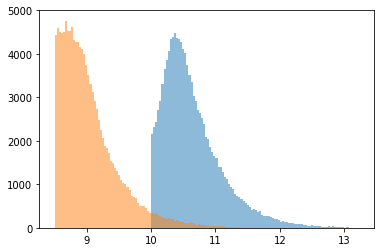

In [5]:
hist(mb2['halos.mass'][m],100,alpha=0.5);
hist(mb2['halos.m_star'][m],100,alpha=0.5);

In [6]:
catalog = mb2[m]
len(catalog['halos.mass'])

119963

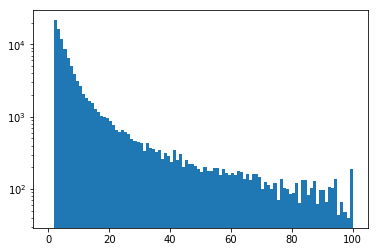

In [7]:
hist(catalog['group_size'],100,range=[0,100]);
yscale('log')

In [8]:
catalog['halos.m_dm_scaled'] = clip(RobustScaler().fit_transform(catalog['halos.m_dm'].reshape((-1,1))),-5,5).squeeze()
catalog['halos.m_star_scaled'] = clip(RobustScaler().fit_transform(catalog['halos.m_star'].reshape((-1,1))),-5,5).squeeze()
catalog['groups.mass_scaled'] = clip(RobustScaler().fit_transform(catalog['groups.mass'].reshape((-1,1))),-5,5).squeeze()

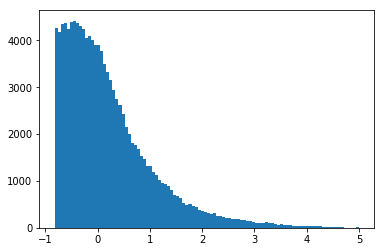

In [9]:
hist(catalog['halos.m_star_scaled'],100);

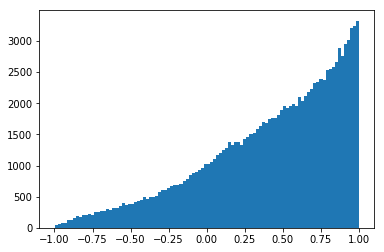

In [10]:
hist(catalog['tid1000.c_x']*catalog['shapesStar.a3d_x'] +
    catalog['tid1000.c_y']*catalog['shapesStar.a3d_y'] +
    catalog['tid1000.c_z']*catalog['shapesStar.a3d_z']  ,100);

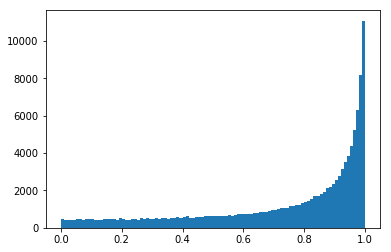

In [11]:
hist(catalog['shapesDM.a3d_x']*catalog['shapesStar.a3d_x'] +
     catalog['shapesDM.a3d_y']*catalog['shapesStar.a3d_y'] +
     catalog['shapesDM.a3d_z']*catalog['shapesStar.a3d_z']  ,100);

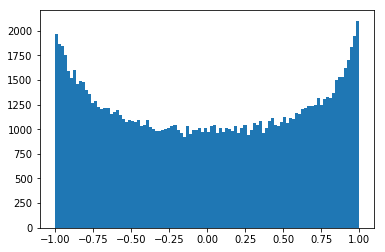

In [12]:
hist(catalog['cen_x']*catalog['shapesStar.a3d_x'] +
     catalog['cen_y']*catalog['shapesStar.a3d_y'] +
     catalog['cen_z']*catalog['shapesStar.a3d_z']  ,100);

## Define network

In [13]:
weighting='exp'
directions = get_3d_direction()
filter_size=directions.shape[-1]

# Define generator function
def conditional_generator_fn(inputs, 
                             is_training=True,
                             reuse=None,
                             scope='Generator',
                             fused_batch_norm=False):

    W0, W1, W2, pm0, pm1, pm2, xsp, X, noise = inputs

    adj = tf.SparseTensor(tf.cast(W0, tf.int64),W1,W2)
    # Computes 3D adjacency matrix
    mr = spatial_adjacency(xsp, adj, directions, filter_size, radial_weighting=weighting, radial_scale=0.4,
                           learn_scale=False)

    # Input level, transforming all inputs features into a single channel
    # First we mix the inputs
    net = graph_conv2(tf.concat([noise, X],axis=1), mr, num_outputs=128, activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=128,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=128,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=64,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    
    # Let's constrain the output to lie on the sphere
    net_a3d = graph_conv2(net, mr, 3, activation_fn=None, one_hop=False)
    net_a3d = tf.nn.l2_normalize(net_a3d, axis=-1)
    
    # Assemble output
    out_net = tf.concat([net_a3d], axis=1)

    return out_net

def conditional_discriminator_fn(y, conditioning):
    """
    Discriminator network that can tell if the galaxies are correctly aligned
    args:
    y: alignment signal
    conditioning: tuple (adj, idn, x_spatial, pool, x, noise)
    """
    W0, W1, W2, pm0, pm1, pm2, xsp, X, noise = conditioning

    adj = tf.SparseTensor(tf.cast(W0, tf.int64),W1,W2)
    pool = tf.SparseTensor(tf.cast(pm0, tf.int64), pm1, pm2)
    
    # Computes 3D adjacency matrices for each multi-resolution level
    mr = spatial_adjacency(xsp, adj, directions, filter_size, radial_weighting=weighting, learn_scale=False, 
                           radial_scale=0.2)

    net = graph_conv2(tf.concat([y, X],axis=1), mr, num_outputs=128, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 128, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 64, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 32, activation_fn=tf.nn.leaky_relu)

    # Apply spatial pooling
    net = tf.sparse_tensor_dense_matmul(pool, net)

    net = slim.fully_connected(net, 1, activation_fn=None)

    return net

In [14]:
import tensorflow.contrib.gan as tfgan
from tensorflow.contrib.gan.python import namedtuples

my_config = tf.estimator.RunConfig(
    save_checkpoints_steps = 2000,
    keep_checkpoint_max = 100,       # Retain the 10 most recent checkpoints.
)

def silly_custom_discriminator_loss(gan_model, add_summaries=True):
    return tf.reduce_mean(gan_model.discriminator_real_outputs**2)

# Initialize GANEstimator with options and hyperparameters.
gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=conditional_generator_fn,
    discriminator_fn=conditional_discriminator_fn,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=lambda *args, **kwargs: (tfgan.losses.wasserstein_discriminator_loss(*args, **kwargs) + 
                                                   10.*gradient_penaly(*args, **kwargs)+
                                                   0.001*silly_custom_discriminator_loss(*args, **kwargs)),   
    generator_optimizer=tf.train.AdamOptimizer(0.0001, beta1=0., beta2=0.9),
    discriminator_optimizer=tf.train.AdamOptimizer(0.0001, beta1=0., beta2=0.9),
    get_hooks_fn=tfgan.get_sequential_train_hooks(train_steps=namedtuples.GANTrainSteps(1, 3)),
    model_dir='/data2/graphs4ia/ndp_fixed_new1', 
    config=my_config)

INFO:tensorflow:Using config: {'_model_dir': '/data2/graphs4ia/ndp_fixed_new1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 2000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 100, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fec5d910d30>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [15]:
training_fn = partial(graph_input_fn, catalog,
                      scalar_features=('halos.m_star_scaled','halos.central', 'groups.mass_scaled'),
                      vector_features=('tid1000.a_x', 'tid1000.a_y', 'tid1000.a_z',
                                       'tid1000.b_x', 'tid1000.b_y', 'tid1000.b_z',
                                       'tid1000.c_x', 'tid1000.c_y', 'tid1000.c_z'),
                      
                      vector_labels=('shapesDM.a3d_x', 'shapesDM.a3d_y', 'shapesDM.a3d_z'),
                      shuffle=True, rotate=True, repeat=True, noise_size=32, batch_size=64)

testing_fn = partial(graph_input_fn, catalog,
                      scalar_features=('halos.m_star_scaled','halos.central', 'groups.mass_scaled'),
                      vector_features=('tid1000.a_x', 'tid1000.a_y', 'tid1000.a_z',
                                       'tid1000.b_x', 'tid1000.b_y', 'tid1000.b_z',
                                       'tid1000.c_x', 'tid1000.c_y', 'tid1000.c_z'),
                      vector_labels=('shapesDM.a3d_x', 'shapesDM.a3d_y', 'shapesDM.a3d_z'),
                      shuffle=False, rotate=False, repeat=False, noise_size=32, batch_size=64)

In [ ]:
gan_estimator.train(training_fn, steps=10000)

Precomputing dataset
Done
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /data2/graphs4ia/ndp_fixed_new1/model.ckpt.
INFO:tensorflow:loss = 6.1087904, step = 1
INFO:tensorflow:global_step/sec: 4.38419
INFO:tensorflow:loss = 1.7800143, step = 101 (22.809 sec)
INFO:tensorflow:global_step/sec: 5.20203
INFO:tensorflow:loss = 0.93738884, step = 201 (19.223 sec)


In [92]:
gan_estimator.train(training_fn, steps=100000)

Precomputing dataset
Done
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/graphs4ia/ndp_fixed5/model.ckpt-18000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 18000 into /data2/graphs4ia/ndp_fixed5/model.ckpt.
INFO:tensorflow:loss = -0.07595154, step = 18001
INFO:tensorflow:global_step/sec: 3.11781
INFO:tensorflow:loss = -0.17311972, step = 18101 (32.074 sec)
INFO:tensorflow:global_step/sec: 3.56637
INFO:tensorflow:loss = -0.034209386, step = 18201 (28.040 sec)
INFO:tensorflow:global_step/sec: 3.55378
INFO:tensorflow:loss = 0.06947391, step = 18301 (28.139 sec)
INFO:tensorflow:global_step/sec: 3.56458
INFO:tensorflow:loss = -0.08491993, step = 18401 (28.054 sec)
INFO:tensorflow:global_step/sec: 3.55071
INFO:tensorflow:loss = -0.09098148, step = 18501 (28.163 s

INFO:tensorflow:loss = -0.23786408, step = 25101 (28.545 sec)
INFO:tensorflow:global_step/sec: 3.52909
INFO:tensorflow:loss = 0.063174255, step = 25201 (28.336 sec)
INFO:tensorflow:global_step/sec: 3.49991
INFO:tensorflow:loss = 0.07302572, step = 25301 (28.572 sec)
INFO:tensorflow:global_step/sec: 3.50433
INFO:tensorflow:loss = 0.10402921, step = 25401 (28.536 sec)
INFO:tensorflow:global_step/sec: 3.5172
INFO:tensorflow:loss = 0.017031297, step = 25501 (28.432 sec)
INFO:tensorflow:global_step/sec: 3.49787
INFO:tensorflow:loss = 0.4117156, step = 25601 (28.588 sec)
INFO:tensorflow:global_step/sec: 3.49234
INFO:tensorflow:loss = -0.06257942, step = 25701 (28.634 sec)
INFO:tensorflow:global_step/sec: 3.51247
INFO:tensorflow:loss = -0.024751283, step = 25801 (28.470 sec)
INFO:tensorflow:global_step/sec: 3.49834
INFO:tensorflow:loss = 0.26165366, step = 25901 (28.585 sec)
INFO:tensorflow:Saving checkpoints for 26000 into /data2/graphs4ia/ndp_fixed5/model.ckpt.
INFO:tensorflow:global_step/s

INFO:tensorflow:global_step/sec: 3.49934
INFO:tensorflow:loss = -0.1867229, step = 32801 (28.577 sec)
INFO:tensorflow:global_step/sec: 3.5157
INFO:tensorflow:loss = 0.12506464, step = 32901 (28.444 sec)
INFO:tensorflow:global_step/sec: 3.51794
INFO:tensorflow:loss = -0.08632678, step = 33001 (28.426 sec)
INFO:tensorflow:global_step/sec: 3.5093
INFO:tensorflow:loss = -0.15269786, step = 33101 (28.496 sec)
INFO:tensorflow:global_step/sec: 3.50271
INFO:tensorflow:loss = -0.1584832, step = 33201 (28.549 sec)
INFO:tensorflow:global_step/sec: 3.51199
INFO:tensorflow:loss = 0.35263404, step = 33301 (28.473 sec)
INFO:tensorflow:global_step/sec: 3.52444
INFO:tensorflow:loss = 0.07616155, step = 33401 (28.373 sec)
INFO:tensorflow:global_step/sec: 3.50294
INFO:tensorflow:loss = 0.09358199, step = 33501 (28.548 sec)
INFO:tensorflow:global_step/sec: 3.5004
INFO:tensorflow:loss = 0.22651978, step = 33601 (28.568 sec)
INFO:tensorflow:global_step/sec: 3.51211
INFO:tensorflow:loss = -0.09375665, step =

INFO:tensorflow:global_step/sec: 3.53314
INFO:tensorflow:loss = 0.07865907, step = 40501 (28.303 sec)
INFO:tensorflow:global_step/sec: 3.51062
INFO:tensorflow:loss = -0.006793011, step = 40601 (28.485 sec)
INFO:tensorflow:global_step/sec: 3.52274
INFO:tensorflow:loss = 0.07395127, step = 40701 (28.387 sec)
INFO:tensorflow:global_step/sec: 3.51078
INFO:tensorflow:loss = 0.20161921, step = 40801 (28.483 sec)
INFO:tensorflow:global_step/sec: 3.51682
INFO:tensorflow:loss = -0.009966478, step = 40901 (28.435 sec)
INFO:tensorflow:global_step/sec: 3.5257
INFO:tensorflow:loss = 0.2608168, step = 41001 (28.363 sec)
INFO:tensorflow:global_step/sec: 3.52226
INFO:tensorflow:loss = 0.16520947, step = 41101 (28.391 sec)
INFO:tensorflow:global_step/sec: 3.52866
INFO:tensorflow:loss = 0.12820326, step = 41201 (28.339 sec)
INFO:tensorflow:global_step/sec: 3.50365
INFO:tensorflow:loss = 0.17972024, step = 41301 (28.542 sec)
INFO:tensorflow:global_step/sec: 3.5104
INFO:tensorflow:loss = 0.28079313, step 

INFO:tensorflow:global_step/sec: 3.54799
INFO:tensorflow:loss = 0.16341545, step = 48201 (28.185 sec)
INFO:tensorflow:global_step/sec: 3.54007
INFO:tensorflow:loss = 0.10121256, step = 48301 (28.248 sec)
INFO:tensorflow:global_step/sec: 3.53168
INFO:tensorflow:loss = 0.061753232, step = 48401 (28.315 sec)
INFO:tensorflow:global_step/sec: 3.52349
INFO:tensorflow:loss = -0.017854802, step = 48501 (28.381 sec)
INFO:tensorflow:global_step/sec: 3.49277
INFO:tensorflow:loss = 0.11769056, step = 48601 (28.630 sec)
INFO:tensorflow:global_step/sec: 3.52289
INFO:tensorflow:loss = 0.0592068, step = 48701 (28.386 sec)
INFO:tensorflow:global_step/sec: 3.50612
INFO:tensorflow:loss = 0.06275024, step = 48801 (28.521 sec)
INFO:tensorflow:global_step/sec: 3.53492
INFO:tensorflow:loss = 0.09640727, step = 48901 (28.289 sec)
INFO:tensorflow:global_step/sec: 3.50901
INFO:tensorflow:loss = 0.19932234, step = 49001 (28.498 sec)
INFO:tensorflow:global_step/sec: 3.48865
INFO:tensorflow:loss = -0.0033894628, s

INFO:tensorflow:Saving checkpoints for 56000 into /data2/graphs4ia/ndp_fixed5/model.ckpt.
INFO:tensorflow:global_step/sec: 1.89198
INFO:tensorflow:loss = 0.32092208, step = 56001 (52.855 sec)
INFO:tensorflow:global_step/sec: 3.55617
INFO:tensorflow:loss = -0.4218741, step = 56101 (28.120 sec)
INFO:tensorflow:global_step/sec: 3.5464
INFO:tensorflow:loss = 0.018998444, step = 56201 (28.198 sec)
INFO:tensorflow:global_step/sec: 3.52496
INFO:tensorflow:loss = 0.014475742, step = 56301 (28.369 sec)
INFO:tensorflow:global_step/sec: 3.52256
INFO:tensorflow:loss = -0.031517923, step = 56401 (28.388 sec)
INFO:tensorflow:global_step/sec: 3.52572
INFO:tensorflow:loss = 0.22035813, step = 56501 (28.364 sec)
INFO:tensorflow:global_step/sec: 3.51814
INFO:tensorflow:loss = 0.11461358, step = 56601 (28.424 sec)
INFO:tensorflow:global_step/sec: 3.50124
INFO:tensorflow:loss = 0.485005, step = 56701 (28.561 sec)
INFO:tensorflow:global_step/sec: 3.50638
INFO:tensorflow:loss = 0.13855152, step = 56801 (28.

INFO:tensorflow:global_step/sec: 3.52374
INFO:tensorflow:loss = 0.17402713, step = 63701 (28.378 sec)
INFO:tensorflow:global_step/sec: 3.51134
INFO:tensorflow:loss = -0.11735998, step = 63801 (28.479 sec)
INFO:tensorflow:global_step/sec: 3.53622
INFO:tensorflow:loss = 0.33106917, step = 63901 (28.279 sec)
INFO:tensorflow:Saving checkpoints for 64000 into /data2/graphs4ia/ndp_fixed5/model.ckpt.
INFO:tensorflow:global_step/sec: 1.9054
INFO:tensorflow:loss = 0.31630886, step = 64001 (52.482 sec)
INFO:tensorflow:global_step/sec: 3.53323
INFO:tensorflow:loss = -0.36943427, step = 64101 (28.303 sec)
INFO:tensorflow:global_step/sec: 3.54463
INFO:tensorflow:loss = 0.07311301, step = 64201 (28.212 sec)
INFO:tensorflow:global_step/sec: 3.55219
INFO:tensorflow:loss = 0.1478048, step = 64301 (28.151 sec)
INFO:tensorflow:global_step/sec: 3.5275
INFO:tensorflow:loss = 0.29900083, step = 64401 (28.349 sec)
INFO:tensorflow:global_step/sec: 3.50694
INFO:tensorflow:loss = 0.24545458, step = 64501 (28.51

INFO:tensorflow:global_step/sec: 3.51331
INFO:tensorflow:loss = 0.04362654, step = 71401 (28.463 sec)
INFO:tensorflow:global_step/sec: 3.49749
INFO:tensorflow:loss = 0.22852483, step = 71501 (28.592 sec)
INFO:tensorflow:global_step/sec: 3.52218
INFO:tensorflow:loss = 0.20006457, step = 71601 (28.392 sec)
INFO:tensorflow:global_step/sec: 3.52448
INFO:tensorflow:loss = 0.1251834, step = 71701 (28.372 sec)
INFO:tensorflow:global_step/sec: 3.51303
INFO:tensorflow:loss = -0.07913442, step = 71801 (28.466 sec)
INFO:tensorflow:global_step/sec: 3.52569
INFO:tensorflow:loss = 0.068136536, step = 71901 (28.363 sec)
INFO:tensorflow:Saving checkpoints for 72000 into /data2/graphs4ia/ndp_fixed5/model.ckpt.
INFO:tensorflow:global_step/sec: 1.89219
INFO:tensorflow:loss = 0.2718832, step = 72001 (52.849 sec)
INFO:tensorflow:global_step/sec: 3.52749
INFO:tensorflow:loss = -0.20368496, step = 72101 (28.349 sec)
INFO:tensorflow:global_step/sec: 3.52917
INFO:tensorflow:loss = 0.091665864, step = 72201 (28

INFO:tensorflow:global_step/sec: 3.49762
INFO:tensorflow:loss = 0.10674296, step = 79101 (28.591 sec)
INFO:tensorflow:global_step/sec: 3.50918
INFO:tensorflow:loss = -0.124107875, step = 79201 (28.497 sec)
INFO:tensorflow:global_step/sec: 3.50448
INFO:tensorflow:loss = 0.037438598, step = 79301 (28.535 sec)
INFO:tensorflow:global_step/sec: 3.5199
INFO:tensorflow:loss = 0.08661717, step = 79401 (28.410 sec)
INFO:tensorflow:global_step/sec: 3.50491
INFO:tensorflow:loss = -0.14372253, step = 79501 (28.532 sec)
INFO:tensorflow:global_step/sec: 3.52357
INFO:tensorflow:loss = 0.26693925, step = 79601 (28.380 sec)
INFO:tensorflow:global_step/sec: 3.52379
INFO:tensorflow:loss = 0.015983596, step = 79701 (28.379 sec)
INFO:tensorflow:global_step/sec: 3.50222
INFO:tensorflow:loss = -0.01732701, step = 79801 (28.553 sec)
INFO:tensorflow:global_step/sec: 3.50865
INFO:tensorflow:loss = 0.039870277, step = 79901 (28.501 sec)
INFO:tensorflow:Saving checkpoints for 80000 into /data2/graphs4ia/ndp_fixed

INFO:tensorflow:global_step/sec: 3.53086
INFO:tensorflow:loss = 0.058806054, step = 86801 (28.322 sec)
INFO:tensorflow:global_step/sec: 3.51435
INFO:tensorflow:loss = 0.39517045, step = 86901 (28.455 sec)
INFO:tensorflow:global_step/sec: 3.50658
INFO:tensorflow:loss = 0.5833426, step = 87001 (28.518 sec)
INFO:tensorflow:global_step/sec: 3.52637
INFO:tensorflow:loss = 0.27942616, step = 87101 (28.357 sec)
INFO:tensorflow:global_step/sec: 3.5224
INFO:tensorflow:loss = -0.06281595, step = 87201 (28.390 sec)
INFO:tensorflow:global_step/sec: 3.50677
INFO:tensorflow:loss = 0.04299628, step = 87301 (28.518 sec)
INFO:tensorflow:global_step/sec: 3.51951
INFO:tensorflow:loss = 0.17140158, step = 87401 (28.412 sec)
INFO:tensorflow:global_step/sec: 3.49999
INFO:tensorflow:loss = -0.042089052, step = 87501 (28.572 sec)
INFO:tensorflow:global_step/sec: 3.5145
INFO:tensorflow:loss = 0.25246474, step = 87601 (28.454 sec)
INFO:tensorflow:global_step/sec: 3.51926
INFO:tensorflow:loss = -0.17011361, step

INFO:tensorflow:global_step/sec: 3.51342
INFO:tensorflow:loss = 0.13147934, step = 94501 (28.462 sec)
INFO:tensorflow:global_step/sec: 3.50092
INFO:tensorflow:loss = 0.32365775, step = 94601 (28.564 sec)
INFO:tensorflow:global_step/sec: 3.51329
INFO:tensorflow:loss = -0.007106416, step = 94701 (28.463 sec)
INFO:tensorflow:global_step/sec: 3.51715
INFO:tensorflow:loss = 0.11211713, step = 94801 (28.433 sec)
INFO:tensorflow:global_step/sec: 3.50205
INFO:tensorflow:loss = 0.27569044, step = 94901 (28.554 sec)
INFO:tensorflow:global_step/sec: 3.49705
INFO:tensorflow:loss = 0.113891885, step = 95001 (28.595 sec)
INFO:tensorflow:global_step/sec: 3.53339
INFO:tensorflow:loss = 0.5172051, step = 95101 (28.302 sec)
INFO:tensorflow:global_step/sec: 3.51165
INFO:tensorflow:loss = -0.20116617, step = 95201 (28.476 sec)
INFO:tensorflow:global_step/sec: 3.51662
INFO:tensorflow:loss = -0.41372824, step = 95301 (28.437 sec)
INFO:tensorflow:global_step/sec: 3.49416
INFO:tensorflow:loss = 0.104556575, s

INFO:tensorflow:global_step/sec: 3.5499
INFO:tensorflow:loss = 0.1993168, step = 102201 (28.170 sec)
INFO:tensorflow:global_step/sec: 3.55064
INFO:tensorflow:loss = -0.018842667, step = 102301 (28.164 sec)
INFO:tensorflow:global_step/sec: 3.514
INFO:tensorflow:loss = 0.19232562, step = 102401 (28.458 sec)
INFO:tensorflow:global_step/sec: 3.52721
INFO:tensorflow:loss = -0.15936881, step = 102501 (28.351 sec)
INFO:tensorflow:global_step/sec: 3.49181
INFO:tensorflow:loss = -0.35066187, step = 102601 (28.639 sec)
INFO:tensorflow:global_step/sec: 3.5245
INFO:tensorflow:loss = 0.17800578, step = 102701 (28.373 sec)
INFO:tensorflow:global_step/sec: 3.50248
INFO:tensorflow:loss = -0.037238553, step = 102801 (28.551 sec)
INFO:tensorflow:global_step/sec: 3.5278
INFO:tensorflow:loss = 0.33680168, step = 102901 (28.346 sec)
INFO:tensorflow:global_step/sec: 3.51959
INFO:tensorflow:loss = -0.22257057, step = 103001 (28.413 sec)
INFO:tensorflow:global_step/sec: 3.49678
INFO:tensorflow:loss = -0.13517

INFO:tensorflow:global_step/sec: 3.53274
INFO:tensorflow:loss = 0.2731603, step = 109901 (28.307 sec)
INFO:tensorflow:Saving checkpoints for 110000 into /data2/graphs4ia/ndp_fixed5/model.ckpt.
INFO:tensorflow:global_step/sec: 1.89455
INFO:tensorflow:loss = 0.6360173, step = 110001 (52.783 sec)
INFO:tensorflow:global_step/sec: 3.53927
INFO:tensorflow:loss = -0.13527513, step = 110101 (28.254 sec)
INFO:tensorflow:global_step/sec: 3.54856
INFO:tensorflow:loss = 0.13407747, step = 110201 (28.181 sec)
INFO:tensorflow:global_step/sec: 3.5295
INFO:tensorflow:loss = 0.31427816, step = 110301 (28.332 sec)
INFO:tensorflow:global_step/sec: 3.53236
INFO:tensorflow:loss = -0.915537, step = 110401 (28.310 sec)
INFO:tensorflow:global_step/sec: 3.50867
INFO:tensorflow:loss = 0.9820002, step = 110501 (28.502 sec)
INFO:tensorflow:global_step/sec: 3.52095
INFO:tensorflow:loss = 0.433065, step = 110601 (28.400 sec)
INFO:tensorflow:global_step/sec: 3.52339
INFO:tensorflow:loss = 0.9399123, step = 110701 (2

INFO:tensorflow:global_step/sec: 3.53758
INFO:tensorflow:loss = 0.013177536, step = 117501 (28.268 sec)
INFO:tensorflow:global_step/sec: 3.51418
INFO:tensorflow:loss = 0.40361282, step = 117601 (28.456 sec)
INFO:tensorflow:global_step/sec: 3.54206
INFO:tensorflow:loss = -0.0869737, step = 117701 (28.232 sec)
INFO:tensorflow:global_step/sec: 3.52113
INFO:tensorflow:loss = 0.52854735, step = 117801 (28.400 sec)
INFO:tensorflow:global_step/sec: 3.5111
INFO:tensorflow:loss = -0.103137076, step = 117901 (28.481 sec)
INFO:tensorflow:Saving checkpoints for 118000 into /data2/graphs4ia/ndp_fixed5/model.ckpt.
INFO:tensorflow:Loss for final step: 0.021085128.


In [93]:
gen = gan_estimator.predict(testing_fn, yield_single_examples=False)
toto = concatenate([g for g in gen])
cat = Table(toto, names=['shapesDMs.a3d_x', 'shapesDMs.a3d_y', 'shapesDMs.a3d_z'])

Precomputing dataset
Done
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/graphs4ia/ndp_fixed5/model.ckpt-118000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [94]:
cat['halos.subfindId'] = catalog['halos.subfindId']

In [95]:
from astropy.table import join
res = join(cat,catalog)

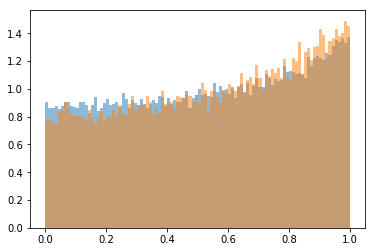

In [96]:
m = res['halos.central'] == 1
hist(abs(res['shapesDMs.a3d_x']*res['shapesDM.a3d_x'] +res['shapesDMs.a3d_y']*res['shapesDM.a3d_y'] +  res['shapesDMs.a3d_z']*res['shapesDM.a3d_z'])[m],100, alpha=0.5,normed=True);
m = res['halos.central'] == 0
hist(abs(res['shapesDMs.a3d_x']*res['shapesDM.a3d_x'] +res['shapesDMs.a3d_y']*res['shapesDM.a3d_y'] +  res['shapesDMs.a3d_z']*res['shapesDM.a3d_z'])[m],100, alpha=0.5, normed=True);

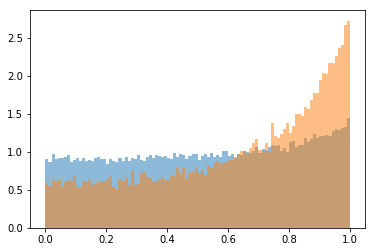

In [97]:
m = res['halos.central'] == 1
hist(abs(res['shapesDMs.a3d_x']*res['cen_x'] +res['shapesDMs.a3d_y']*res['cen_y'] +  res['shapesDMs.a3d_z']*res['cen_z'])[m],100, alpha=0.5,normed=True);
m = res['halos.central'] == 0
hist(abs(res['shapesDMs.a3d_x']*res['cen_x'] +res['shapesDMs.a3d_y']*res['cen_y'] +  res['shapesDMs.a3d_z']*res['cen_z'])[m],100, alpha=0.5,normed=True);

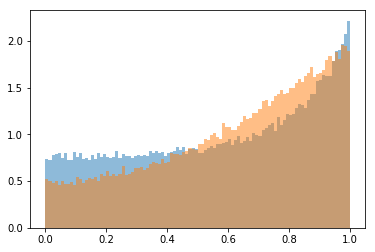

In [98]:
m = res['halos.central'] == 1
hist(abs(res['tid1000.c_x']*res['shapesDM.a3d_x'] +res['shapesDM.a3d_y']*res['tid1000.c_y'] +  res['shapesDM.a3d_z']*res['tid1000.c_z'])[m],100, alpha=0.5,normed=True);
m = res['halos.central'] == 1
hist(abs(res['tid1000.c_x']*res['shapesDMs.a3d_x'] +res['shapesDMs.a3d_y']*res['tid1000.c_y'] +  res['shapesDMs.a3d_z']*res['tid1000.c_z'])[m],100, alpha=0.5,normed=True);

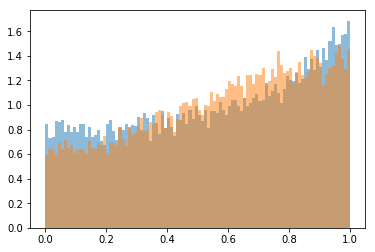

In [99]:
m = res['halos.central'] == 0
hist(abs(res['tid1000.c_x']*res['shapesDM.a3d_x'] +res['shapesDM.a3d_y']*res['tid1000.c_y'] +  res['shapesDM.a3d_z']*res['tid1000.c_z'])[m],100, alpha=0.5,normed=True);
m = res['halos.central'] == 0
hist(abs(res['tid1000.c_x']*res['shapesDMs.a3d_x'] +res['shapesDMs.a3d_y']*res['tid1000.c_y'] +  res['shapesDMs.a3d_z']*res['tid1000.c_z'])[m],100, alpha=0.5,normed=True);

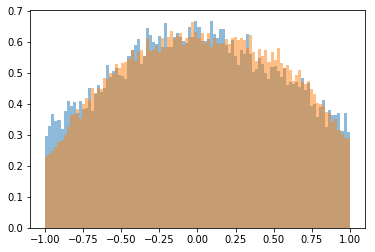

In [100]:
m = res['halos.central'] == 0
hist((res['tid1000.a_x']*res['shapesDM.a3d_x'] +res['shapesDM.a3d_y']*res['tid1000.a_y'] +  res['shapesDM.a3d_z']*res['tid1000.a_z'])[m],100, alpha=0.5,normed=True);
m = res['halos.central'] == 1
hist((res['tid1000.a_x']*res['shapesDMs.a3d_x'] +res['shapesDMs.a3d_y']*res['tid1000.a_y'] +  res['shapesDMs.a3d_z']*res['tid1000.a_z'])[m],100, alpha=0.5,normed=True);

In [101]:
rbins = np.logspace(-1.5,1.5,16)

pos = array([res['halos.x'], res['halos.y'], res['halos.z']]).T
or1 = array([res['shapesDM.a3d_x'], res['shapesDM.a3d_y'], res['shapesDM.a3d_z']]).T 
or2 = array([res['shapesDMs.a3d_x'], res['shapesDMs.a3d_y'], res['shapesDMs.a3d_z']]).T 
gid = squeeze(array([res['groups.groupId']]))

In [106]:
mpos = (res['halos.central'] >-1) & (res['groups.x'] < 50)& (res['groups.y'] < 50)& (res['groups.z'] < 50)
mor  = (res['halos.central'] >-1) 

# Adds a mass cut& (res['groups.x'] < 25)& (res['groups.x'] < 25)
m = (res['halos.m_star'] > 0) & (res['groups.x'] < 50)& (res['groups.y'] < 50)& (res['groups.z'] < 50)

In [107]:
from halotools.mock_observables.alignments import ed_3d,ee_3d, ed_3d_one_two_halo_decomp

In [108]:
ed1h,ed2h = ed_3d_one_two_halo_decomp(pos[mor & m], or1[mor & m], gid[mor & m],  pos[mpos], gid[mpos], rbins, period=None, num_threads=12)
ed1h2,ed2h2 = ed_3d_one_two_halo_decomp(pos[mor & m], or2[mor & m], gid[mor & m],  pos[mpos], gid[mpos], rbins, period=None, num_threads=12)

(0.1, 50)

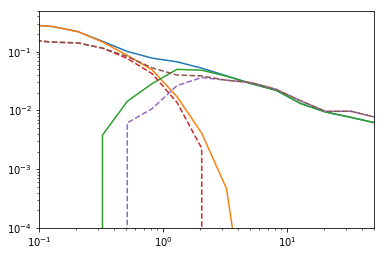

In [109]:
# Without mass cut all-all
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed2h)

loglog(rbins[1:] + rbins[:-1], ed1h2,'--')
loglog(rbins[1:] + rbins[:-1], ed2h2,'--')
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2,'--')
ylim(0.0001, 0.5)
xlim(0.1,50)

(0.1, 50)

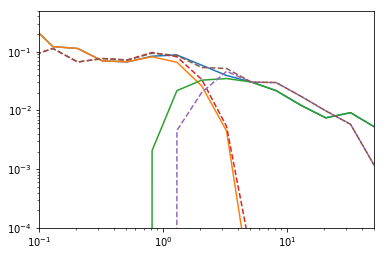

In [91]:
# Without mass cut sat-sat
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed2h)

loglog(rbins[1:] + rbins[:-1], ed1h2,'--')
loglog(rbins[1:] + rbins[:-1], ed2h2,'--')
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2,'--')
ylim(0.0001, 0.5)
xlim(0.1,50)

(0.1, 50)

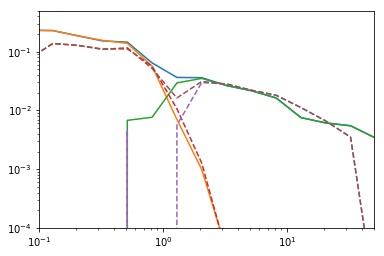

In [86]:
# Without mass cut cent-sat
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed2h)

loglog(rbins[1:] + rbins[:-1], ed1h2,'--')
loglog(rbins[1:] + rbins[:-1], ed2h2,'--')
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2,'--')
ylim(0.0001, 0.5)
xlim(0.1,50)

(0.1, 50)

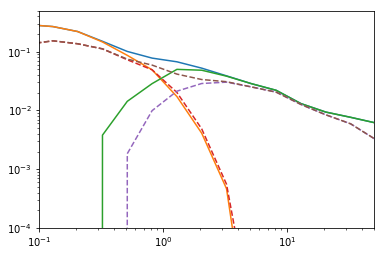

In [82]:
# Without mass cut all-all
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed2h)

loglog(rbins[1:] + rbins[:-1], ed1h2,'--')
loglog(rbins[1:] + rbins[:-1], ed2h2,'--')
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2,'--')
ylim(0.0001, 0.5)
xlim(0.1,50)

(0.1, 50)

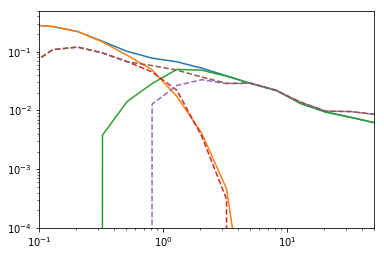

In [65]:
# Without mass cut all-all
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed2h)

loglog(rbins[1:] + rbins[:-1], ed1h2,'--')
loglog(rbins[1:] + rbins[:-1], ed2h2,'--')
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2,'--')
ylim(0.0001, 0.5)
xlim(0.1,50)

(0.06, 200)

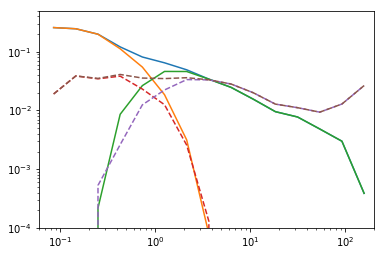

In [34]:
# Without mass cut all-all
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed2h)

loglog(rbins[1:] + rbins[:-1], ed1h2,'--')
loglog(rbins[1:] + rbins[:-1], ed2h2,'--')
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2,'--')
ylim(0.0001, 0.5)
xlim(0.06,200)